# Dog Breed Image Classification Model

This notebook will build the final version of our Dog Breed Image Classification Model. Information about the model we selected can be found in [ml_model_exploration.ipynb](ml_model_exploration.ipynb)

## Setup

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
import pathlib
import joblib
import re

tf.get_logger().setLevel('ERROR')

In [48]:
# making sure that tensorflow is going to be using GPU for calculations
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Loading

In [49]:
# set up connection to folder
data_dir = "../Dog_Breed_Files/Images/"
data_dir = pathlib.Path(data_dir)

In [50]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

19429


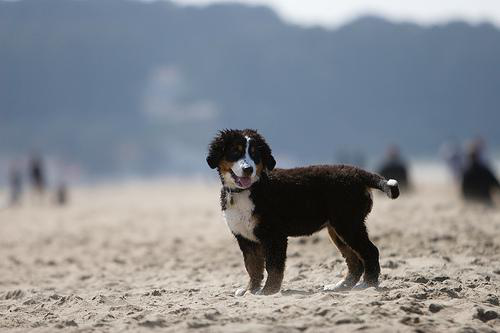

In [51]:
# confirm connection by checking out a bernese mountain dog
dog = list(data_dir.glob('n02107683-Bernese_mountain_dog/*'))
PIL.Image.open(str(dog[51]))

## Set up Data

While we're aware of the "image_dataset_from_directory()" keras utility, we're going to set up a custom image preprocessing pipeline for maximum flexibility with tuning model parameters and for deploying the model later.

We will want all of the images to be the same size and for processing to work in batches.

In [52]:
# define parameters to be used in loading and modeling
batch_size = 32
img_height = 224
img_width = 224

In [53]:
# set up a list that contains every photo in the directory
image_list = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
image_list = image_list.shuffle(image_count, reshuffle_each_iteration=False)

### Building Class Labels

In [54]:
# investigate the file path for the photos
for image in image_list.take(3):
    print(image.numpy())

b'..\\Dog_Breed_Files\\Images\\n02091134-whippet\\n02091134_15038.jpg'
b'..\\Dog_Breed_Files\\Images\\n02098105-soft-coated_wheaten_terrier\\n02098105_1386.jpg'
b'..\\Dog_Breed_Files\\Images\\n02096294-Australian_terrier\\n02096294_2206.jpg'


In [55]:
# note the folder names have a lot of extra info in them. when we get an answer at the end we'll use a dataframe to grab the cleaned name from the messy folder name
class_names = []

for folder_name in os.listdir("../Dog_Breed_Files/Images/"):
    class_names.append(folder_name)

### Set up Train/Test Split

Going to use an 80/20 train test split here. (can revisit later)

In [56]:
test_size = int(image_count*0.2)
train_data = image_list.skip(test_size)
test_data = image_list.take(test_size)

In [57]:
# check size of our training and testing data (expecting sum to be 19,429)
print(tf.data.experimental.cardinality(train_data).numpy())
print(tf.data.experimental.cardinality(test_data).numpy())
print(tf.data.experimental.cardinality(train_data).numpy() + tf.data.experimental.cardinality(test_data).numpy())

15544
3885
19429


### Functions for loading and preprocessing

In [58]:
# this will look at the file path and assign it a number [0-119] based on which dog breed it is (number is relative to where it lies in the folder structure)
def get_label(file_path):
    # take the path and separate it into components by the /
    parts = tf.strings.split(file_path, os.path.sep)
    
    # looking at the file structure above, the 2nd to last element is the class directory
    one_hot = parts[-2] == class_names

    # integer encode the label
    label = tf.argmax(one_hot)
    return label

In [59]:
# this will look at the image in a file path, turn it into an RGB array, then resize it to our desired size
def decode_image(img):
    img = tf.io.read_file(img)

    # parse the image as a uint8 tensor, 3 channels for RGB color
    img = tf.image.decode_jpeg(img, channels=3)

    # convert color channels from [0-255] to [0-1]. done here as opposed to in a model layer for increased efficiency
    img = tf.image.convert_image_dtype(img, tf.float32)

    # resize the image to  standardized size
    img = tf.image.resize(img, [img_height, img_width])
    return img

In [60]:
# this will combine the two functions above to get a label and an encoded tensor for each image it looks at
def processing(file_path):
    # get the folder name
    label = get_label(file_path)
    
    # load image, decode image
    img = decode_image(file_path)
    return img, label

In [61]:
# map the processing pipeline to each data set. 
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.map(processing)
test_data = test_data.map(processing)

In [62]:
# expecting each image to be (224, 224, 3) shape
for image, label in train_data.take(3):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  110
Image shape:  (224, 224, 3)
Label:  76
Image shape:  (224, 224, 3)
Label:  86


### Set up performance features

In [63]:
def performance_enhance(dataset):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [64]:
train_data = performance_enhance(train_data)
test_data = performance_enhance(test_data)
num_classes = len(class_names)

## Building Model

We're going to use a resnet classification model from tfhub.

In [65]:
# set up transfer learning model

resnet = "https://tfhub.dev/tensorflow/resnet_50/classification/1"


base_model = hub.KerasLayer(
    resnet,
    input_shape=(img_height, img_width, 3),
    trainable=False)

In [66]:
# set up callback functions

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5)


# checkpoints
os.makedirs("checkpoints/", exist_ok = True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

In [67]:
# set up our model, starting with the resnet model, then going into a few layers of dense and dropout layers to increase learning chances and help with overfitting
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dropout(.30),
    tf.keras.layers.Dense(180, activation='relu'),
    tf.keras.layers.Dropout(.20),
    tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.build((img_height, img_width, 3))

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              25612201  
                                                                 
 dense_3 (Dense)             (None, 250)               250500    
                                                                 
 dropout_2 (Dropout)         (None, 250)               0         
                                                                 
 dense_4 (Dense)             (None, 180)               45180     
                                                                 
 dropout_3 (Dropout)         (None, 180)               0         
                                                                 
 dense_5 (Dense)             (None, 113)               20453     
                                                                 
Total params: 25,928,334
Trainable params: 316,133
Non

## Training Model
Note: We moved all the checkpoints to the "Dog_Breed_Files" subfolder since they ended up being about 1 GB in size all in all.

In [68]:
epoch = 100

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epoch,
    callbacks=[early_stopping, checkpoints]
    )

Epoch 1/100
485/486 [============================>.] - ETA: 0s - loss: 1.8805 - accuracy: 0.7039
Epoch 1: saving model to checkpoints\weights.01.hdf5
486/486 [==============================] - 44s 79ms/step - loss: 1.8789 - accuracy: 0.7041 - val_loss: 0.5147 - val_accuracy: 0.8741
Epoch 2/100
485/486 [============================>.] - ETA: 0s - loss: 0.5454 - accuracy: 0.8704
Epoch 2: saving model to checkpoints\weights.02.hdf5
486/486 [==============================] - 35s 72ms/step - loss: 0.5450 - accuracy: 0.8704 - val_loss: 0.5022 - val_accuracy: 0.8698
Epoch 3/100
485/486 [============================>.] - ETA: 0s - loss: 0.5030 - accuracy: 0.8744
Epoch 3: saving model to checkpoints\weights.03.hdf5
486/486 [==============================] - 35s 72ms/step - loss: 0.5025 - accuracy: 0.8744 - val_loss: 0.4970 - val_accuracy: 0.8767
Epoch 4/100
485/486 [============================>.] - ETA: 0s - loss: 0.4701 - accuracy: 0.8808
Epoch 4: saving model to checkpoints\weights.04.hdf5
4

## Evaluation

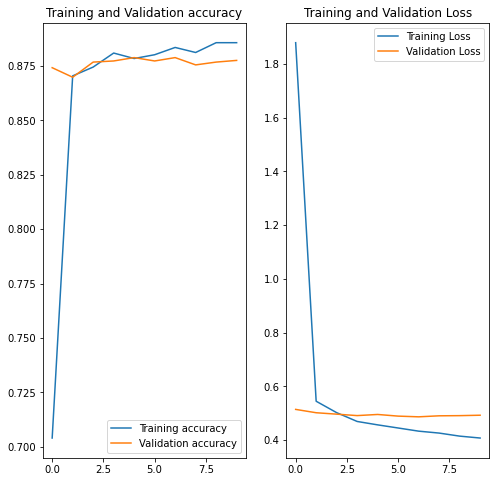

In [69]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('fivethirtyeight')
plt.show()


## Cleaning Class Labels

We'll make both a function and a dictionary that can be used with the model output to get the cleaned name, for maximum flexibility when it comes to the final product.

In [70]:
def label_clean(label):
    search = re.search('.{9}-(.*)', label)
    
    label_clean = search.group(1).replace("_", " ")\
        .replace("-", " ")\
        .title()\
        .strip()
    return label_clean

In [71]:
labels_dict = {}

for label in class_names:
    new_label = label_clean(label)
    labels_dict[label] = new_label

## Prediction

In [76]:
def image_input(img):
    img = tf.io.read_file(img)

    # parse the image as a uint8 tensor, 3 channels for RGB color
    img = tf.image.decode_jpeg(img, channels=3)

    # convert color channels from [0-255] to [0-1]. done here as opposed to in a model layer for increased efficiency
    img = tf.image.convert_image_dtype(img, tf.float32)

    # resize the image to  standardized size
    img = tf.image.resize(img, [img_height, img_width])

    # expand size so that image matches the shape of binned images used to train the model
    img = np.expand_dims(img, axis=0)

    return img

In [84]:
img_path = '../Dog_Breed_Files/temp/french-bulldog-detail.jpg'
img_input = image_input(img_path)

prediction = model.predict(img_input)
prediction_name = class_names[np.argmax(prediction)]

1/1 [==============================] - 0s 19ms/step


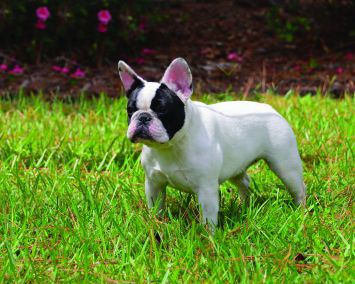

In [85]:
PIL.Image.open(str(img_path))

In [86]:
print(f"predicting: {label_clean(prediction_name)} with a probability of {np.max(prediction)*100:0.2f}%")

predicting: French Bulldog with a probability of 99.78%


## Saving Model

Check if we'll use saved_model objects or if we want to convert this to tflite

In [87]:
model.save('final_export/trained_model.h5')

In [88]:
joblib.dump(model, 'final_export/trained_model.joblib')

['final_trained_model_export/trained_model.joblib']

In [90]:
# code to load the model in a new noteboook (using the .h5 export)
loaded_model = tf.keras.models.load_model('final_trained_model_export/trained_model.h5',
    custom_objects={'KerasLayer': hub.KerasLayer(
    "https://tfhub.dev/tensorflow/resnet_50/classification/1",
    input_shape=(224, 224, 3),
    trainable=False)})

In [91]:
img_path = '../Dog_Breed_Files/temp/french-bulldog-detail.jpg'
new_img_input = image_input(img_path)

new_prediction = model.predict(img_input)
new_prediction_name = class_names[np.argmax(prediction)]

1/1 [==============================] - 0s 22ms/step


In [92]:
print(f"predicting: {label_clean(new_prediction_name)} with a probability of {np.max(prediction)*100:0.2f}%")

predicting: French Bulldog with a probability of 99.78%
